In [1]:
import os

os.environ["PIP_CACHE_DIR"] = "/cs/student/projects1/aibh/2024/rmaheswa/cache"
os.environ["HF_HOME"] = "/cs/student/projects1/aibh/2024/rmaheswa/cache/huggingface"
os.environ["TRANSFORMERS_CACHE"] = "/cs/student/projects1/aibh/2024/rmaheswa/cache/transformers"
os.environ['MPLCONFIGDIR'] = '/cs/student/projects1/aibh/2024/rmaheswa/cache/matplotlib'


In [2]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# from datasets import load_from_disk
# import torch.nn as nn, torch.nn.functional as F
# import torch, json
# from transformers import BertTokenizer, BertModel
# from utils import BertModel as MedBertModel
# from utils import LangCellDataCollatorForCellClassification as DataCollatorForCellClassification
# from tqdm import tqdm
# from torch.utils.data import DataLoader

# class Pooler(nn.Module):
#     def __init__(self, config, pretrained_proj, proj_dim):
#         super().__init__()
#         self.proj = nn.Linear(config.hidden_size, proj_dim)
#         self.proj.load_state_dict(torch.load(pretrained_proj))
#     def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
#         pooled_output = hidden_states[:, 0]
#         pooled_output = F.normalize(self.proj(pooled_output), dim=-1)
#         return pooled_output
    
# model = BertModel.from_pretrained('LangCell/ckpt/cell_bert')
# model.pooler = Pooler(model.config, pretrained_proj='LangCell/ckpt/cell_proj.bin', proj_dim=256)
# proj = model.pooler.proj
# # model = model.module
# model = model.to("cuda")

# text_pretrained_model = 'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext'
# tokenizer = BertTokenizer.from_pretrained(text_pretrained_model)
# tokenizer.add_special_tokens({'bos_token':'[DEC]'})
# tokenizer.add_special_tokens({'additional_special_tokens':['[ENC]']})       
# tokenizer.enc_token_id = tokenizer.additional_special_tokens_ids[0]  
# text_encoder = MedBertModel.from_pretrained('LangCell/ckpt/text_bert', add_pooling_layer=True)
# text_encoder.pooler = Pooler(text_encoder.config, pretrained_proj='LangCell/ckpt/text_proj.bin', proj_dim=256)
# text_encoder = text_encoder.to("cuda")

# ctm_head = nn.Linear(text_encoder.config.hidden_size, 2)
# ctm_head.load_state_dict(torch.load('LangCell/ckpt/ctm_head.bin'))
# ctm_head = ctm_head.to("cuda")

In [3]:
# import anndata as ad
# adata = ad.read_h5ad("/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/pancreas_cancer_with_celltypes.h5ad")

# print(adata.obs.columns)

# print(adata.obs.head())

In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from datasets import load_from_disk
import torch.nn as nn, torch.nn.functional as F
import torch, json
from transformers import BertTokenizer, BertModel
from utils import BertModel as MedBertModel
from utils import LangCellDataCollatorForCellClassification as DataCollatorForCellClassification
from tqdm import tqdm
from torch.utils.data import DataLoader

# Use environment cache dirs if needed
os.environ["PIP_CACHE_DIR"] = "/cs/student/projects1/aibh/2024/rmaheswa/cache"
os.environ["HF_HOME"] = "/cs/student/projects1/aibh/2024/rmaheswa/cache/huggingface"
os.environ["TRANSFORMERS_CACHE"] = "/cs/student/projects1/aibh/2024/rmaheswa/cache/transformers"

class Pooler(nn.Module):
    def __init__(self, config, pretrained_proj, proj_dim):
        super().__init__()
        self.proj = nn.Linear(config.hidden_size, proj_dim)
        self.proj.load_state_dict(torch.load(pretrained_proj))
    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        pooled_output = hidden_states[:, 0]
        pooled_output = F.normalize(self.proj(pooled_output), dim=-1)
        return pooled_output

# Paths
base_path = '/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/ckpt'

# Cell model
model = BertModel.from_pretrained(
    f'{base_path}/cell_bert',
    local_files_only=True
)
model.pooler = Pooler(model.config, pretrained_proj=f'{base_path}/cell_proj.bin', proj_dim=256)
proj = model.pooler.proj
model = model.to("cuda")

# Text encoder
text_pretrained_model = 'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext'
tokenizer = BertTokenizer.from_pretrained(text_pretrained_model)
tokenizer.add_special_tokens({'bos_token': '[DEC]'})
tokenizer.add_special_tokens({'additional_special_tokens': ['[ENC]']})
tokenizer.enc_token_id = tokenizer.additional_special_tokens_ids[0]

text_encoder = MedBertModel.from_pretrained(
    f'{base_path}/text_bert',
    local_files_only=True,
    add_pooling_layer=True
)
text_encoder.pooler = Pooler(text_encoder.config, pretrained_proj=f'{base_path}/text_proj.bin', proj_dim=256)
text_encoder = text_encoder.to("cuda")

# Cell-type matching head
ctm_head = nn.Linear(text_encoder.config.hidden_size, 2)
ctm_head.load_state_dict(torch.load(f'{base_path}/ctm_head.bin'))
ctm_head = ctm_head.to("cuda")


Some weights of BertModel were not initialized from the model checkpoint at /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/ckpt/cell_bert and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
def text_encode(text):
    text = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors='pt').to('cuda')
    text = text_encoder(**text).pooler_output
    # text = F.normalize(model.text_projector(text))
    return text

def cell_encode(cell_input_ids, cell_atts):
    cell = model(cell_input_ids.to("cuda"), cell_atts.to("cuda"))
    cell_last_h = cell.last_hidden_state
    cell_pooler = cell.pooler_output
    return cell_last_h, cell_pooler

def ctm(text, cell_emb, cell_atts):
    text = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors='pt').to('cuda')
    output = text_encoder(**text,
                encoder_hidden_states = cell_emb.to("cuda"),
                encoder_attention_mask = cell_atts.to("cuda"),
                return_dict = True,
                mode = 'multimodal',
                )
    logits = ctm_head(output.last_hidden_state[:, 0, :])
    logits = F.softmax(logits, dim=-1)[..., 1] # [n]
    return logits

In [6]:
from datasets import load_from_disk

In [7]:
dataset = load_from_disk("/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/your_data/tokenized_dataset_prostate_20250803_225023")

dataset_sub = dataset.shuffle(seed=42)  # optionally add .select(range(1000)) for debugging
for label_name in ["celltype", "cell_type", "str_labels", "labels"]:
    if label_name in dataset_sub.column_names:
        break
if label_name != "celltype":
    dataset_sub = dataset_sub.rename_column(label_name, "celltype")

print(set(dataset_sub["celltype"]))

# Inspect your tokenized data
print("Columns:", dataset_sub.column_names)
print("\nFirst example:")
ex = dataset_sub[0]
for k, v in ex.items():
    t = type(v)
    length = len(v) if isinstance(v, (list, tuple)) else "–"
    preview = v[:10] if isinstance(v, (list, tuple)) else v
    print(f"  {k}: {t.__name__}, length={length}, preview={preview}")


{'Malignant', 'Mast', 'Endothelial', 'T_cell', 'Macrophage', 'B_cell', 'Unassigned', 'Epithelial', 'Fibroblast'}
Columns: ['input_ids', 'sample', 'celltype', 'complexity', 'umap1', 'umap2', 'g1s_score', 'g2m_score', 'cell_cycle_phase', 'mp_top_score', 'mp_top', 'mp_assignment', 'sample_technology', 'sample_n_cells', 'sample_patient', 'sample_cancer_type', 'sample_sex', 'sample_age', 'sample_smoking_status', 'sample_PY', 'sample_diagnosis_recurrence', 'sample_disease_extent', 'sample_AJCC_T', 'sample_AJCC_N', 'sample_AJCC_M', 'sample_AJCC_stage', 'sample_sample_primary_met', 'sample_size', 'sample_site', 'sample_histology', 'sample_genetic_hormonal_features', 'sample_grade', 'sample_KI67', 'sample_treated_naive', 'sample_chemotherapy_exposed', 'sample_chemotherapy_response', 'sample_targeted_rx_exposed', 'sample_targeted_rx_response', 'sample_ICB_exposed', 'sample_ICB_response', 'sample_ET_exposed', 'sample_ET_response', 'sample_time_end_of_rx_to_sampling', 'sample_post_sampling_rx_expo

In [8]:
print(set(dataset_sub['celltype']))

{'Malignant', 'Mast', 'Endothelial', 'T_cell', 'Macrophage', 'B_cell', 'Unassigned', 'Epithelial', 'Fibroblast'}


In [10]:
import json
types = list(set(dataset_sub['celltype']))
type2text = json.load(open("/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/your_data/type2text_prostate.json"))
texts = [type2text[typename] for typename in types]
with torch.no_grad():
    text_embs = torch.cat([text_encode(text) for text in texts], 0).T.cuda() # 256 * N
text_embs.requires_grad = False
type2num = dict([(type, i) for i, type in enumerate(types)])

In [ ]:
# def classes_to_ids(example):
#     example["label"] = type2num[example["celltype"]]
#     return example
# testdataset = dataset_sub.map(classes_to_ids, num_proc=16)
# remove_columns = testdataset.column_names
# remove_columns.remove('input_ids')
# remove_columns.remove('label')
# testdataset = testdataset.remove_columns(remove_columns)
# batchsize = 48
# collator = DataCollatorForCellClassification()
# dataloader = DataLoader(testdataset, batch_size=batchsize, collate_fn=collator, shuffle=False)

Map (num_proc=16): 100%|██████████| 138727/138727 [00:15<00:00, 9106.62 examples/s] 


In [11]:
from torch.utils.data import DataLoader

# 1) Map cell‐type strings → numeric labels
def classes_to_ids(example):
    example["label"] = type2num[example["celltype"]]
    return example

testdataset = dataset_sub.map(classes_to_ids, num_proc=16)

# 2) Keep only the fields the model & collator need:
keep_cols = ["input_ids", "attention_mask", "label"]
drop_cols = [c for c in testdataset.column_names if c not in keep_cols]
testdataset = testdataset.remove_columns(drop_cols)

# 3) Build DataLoader with the classification collator
batchsize = 32
collator  = DataCollatorForCellClassification()

dataloader = DataLoader(
    testdataset,
    batch_size=batchsize,
    shuffle=False,
    collate_fn=collator,
    num_workers=4,
    pin_memory=True
)

# 4) Sanity‐check your batch shapes:
batch = next(iter(dataloader))
print(batch.keys())                      # should include 'input_ids','attention_mask','labels'
print(batch['input_ids'].shape)          # e.g. [48, L] with L >> 1
print(batch['attention_mask'].shape)     # same shape as input_ids
print(batch['labels'].shape)             # [48]


Map (num_proc=16): 100%|██████████| 36424/36424 [00:03<00:00, 9964.05 examples/s] 
/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/geneformer_001/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}
/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/geneformer_001/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}
/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/geneformer_001/geneformer/collator_for_classification.py:581

dict_keys(['input_ids', 'attention_mask', 'labels'])
torch.Size([32, 2048])
torch.Size([32, 2048])
torch.Size([32])


In [12]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

# Assumed already defined above:
#   model           – your cell encoder on GPU
#   text_encoder    – your text encoder on GPU
#   ctm_head        – your CTM head on GPU
#   tokenizer       – your text tokenizer
#   dataloader      – DataLoader over your tokenized cells
#   text_embs       – a (proj_dim × n_texts) tensor on GPU
#   texts           – list of length n_texts of description strings
#   batchsize       – batch size used in the dataloader
#   dataset_sub     – your HuggingFace Dataset (for sized-based prealloc)
#   testdataset     – same dataset but with a “label” field if you set it earlier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) Pre-allocate result tensors on GPU
N = len(dataset_sub)
C = text_embs.shape[-1]
cell_embs  = torch.zeros(N, 256, device=device)
preds      = torch.zeros(N,        device=device, dtype=torch.long)
sim_logits = torch.zeros(N,    C,  device=device)
ctm_logits = torch.zeros(N,    C,  device=device)
logits     = torch.zeros(N,    C,  device=device)
labels     = torch.tensor(testdataset['label'], device=device, dtype=torch.long)

model.eval()
text_encoder.eval()
ctm_head.eval()

with torch.no_grad():
    for batch_idx, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Move inputs to GPU
        input_ids      = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        # 2) Encode cells
        cell_last_h, cellemb = cell_encode(input_ids, attention_mask)
        #    cell_last_h: (B, L, H); cellemb: (B, 256)

        # 3) Similarity branch
        sim = (cellemb @ text_embs) / 0.05           # (B, C)
        sim_log = F.softmax(sim, dim=-1)             # (B, C)

        # 4) CTM branch
        B = sim_log.size(0)
        ctm_log = torch.zeros_like(sim_log, device=device)
        for t_idx, txt in enumerate(texts):
            text_list = [txt] * B
            ctm_log[:, t_idx] = ctm(text_list, cell_last_h, attention_mask)
        ctm_log = F.softmax(ctm_log, dim=-1)

        # 5) Combine and predict
        logit = (sim_log + ctm_log) / 2              # (B, C)
        pred  = logit.argmax(dim=-1)                 # (B,)

        # 6) Store results
        start = batch_idx * batchsize
        end   = start + B

        sim_logits[start:end] = sim_log
        ctm_logits[start:end] = ctm_log
        logits[start:end]     = logit
        cell_embs[start:end]  = cellemb
        preds[start:end]      = pred

# 7) Move everything back to CPU for saving
cell_embs_cpu  = cell_embs.cpu()
sim_logits_cpu = sim_logits.cpu()
ctm_logits_cpu = ctm_logits.cpu()
logits_cpu     = logits.cpu()
preds_cpu      = preds.cpu()
labels_cpu     = labels.cpu()

# 8) Save to disk
torch.save({
    'cell_embs':  cell_embs_cpu,
    'sim_logits': sim_logits_cpu,
    'ctm_logits': ctm_logits_cpu,
    'logits':     logits_cpu,
    'preds':      preds_cpu,
    'labels':     labels_cpu
}, '/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/your_data/results_prostate.pt')

  0%|          | 0/1139 [00:00<?, ?it/s]/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/geneformer_001/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}
/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/geneformer_001/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}
/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/geneformer_001/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a ten

In [ ]:

# # %%
# from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, average_precision_score
# import numpy as np
# sim_preds = sim_logits.argmax(dim=-1)
# ctm_preds = ctm_logits.argmax(dim=-1)
# alpha = 0.1
# preds = (alpha * sim_logits + (1 - alpha) * ctm_logits).argmax(dim=-1)
# labels = torch.tensor(testdataset['label'])
# for row in confusion_matrix(labels, preds):
#     print('\t'.join([str(x) for x in row]))
# print(classification_report(labels, preds, digits=4))

In [13]:
# %%
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, average_precision_score
import torch

# Compute predictions if you haven't already:
alpha = 0.1
preds = (alpha * sim_logits + (1 - alpha) * ctm_logits).argmax(dim=-1)

# Move to CPU and convert to NumPy
labels_np = torch.tensor(testdataset['label']).cpu().numpy()
preds_np  = preds.cpu().numpy()

# Now you can safely call sklearn metrics:
cm = confusion_matrix(labels_np, preds_np)
for row in cm:
    print('\t'.join(map(str, row)))

print(classification_report(labels_np, preds_np, digits=4))

# (Optional) If you want ROC AUC / AP scores:
# scores_np = (alpha * sim_logits + (1 - alpha) * ctm_logits).cpu().numpy()
# from sklearn.preprocessing import label_binarize
# n_classes = scores_np.shape[1]
# labels_onehot = label_binarize(labels_np, classes=list(range(n_classes)))
# print("ROC AUC:", roc_auc_score(labels_onehot, scores_np, average="macro", multi_class="ovr"))
# print("Avg Precision:", average_precision_score(labels_onehot, scores_np, average="macro"))


1349	0	0	0	0	0	4	12938	0
278	1226	0	0	2	0	3	19	1
21	0	3196	0	0	1	7	39	14
774	20	5	849	4	139	1687	3	0
85	50	1	2	1447	0	122	4	3
7	1	0	171	1	142	0	0	0
1357	9	74	23	37	23	17	4449	8
1046	0	0	2	1	3	29	2701	0
419	0	22	0	0	0	249	33	1307
              precision    recall  f1-score   support

           0     0.2528    0.0944    0.1375     14291
           1     0.9387    0.8018    0.8649      1529
           2     0.9691    0.9750    0.9720      3278
           3     0.8109    0.2439    0.3750      3481
           4     0.9698    0.8442    0.9027      1714
           5     0.4610    0.4410    0.4508       322
           6     0.0080    0.0028    0.0042      5997
           7     0.1338    0.7142    0.2254      3782
           8     0.9805    0.6438    0.7773      2030

    accuracy                         0.3359     36424
   macro avg     0.6139    0.5290    0.5233     36424
weighted avg     0.4229    0.3359    0.3274     36424



In [14]:
# 5) (Optional) Compute AUC / Average Precision if you have scores
scores_np = (alpha * sim_logits + (1 - alpha) * ctm_logits).cpu().numpy()
from sklearn.preprocessing import label_binarize
n_classes = scores_np.shape[1]
labels_onehot = label_binarize(labels_np, classes=range(n_classes))
roc_auc = roc_auc_score(labels_onehot, scores_np, average="macro", multi_class="ovr")
ap_score = average_precision_score(labels_onehot, scores_np, average="macro")
print(f"ROC AUC: {roc_auc:.4f}, Avg Precision: {ap_score:.4f}")


ROC AUC: 0.8668, Avg Precision: 0.6398


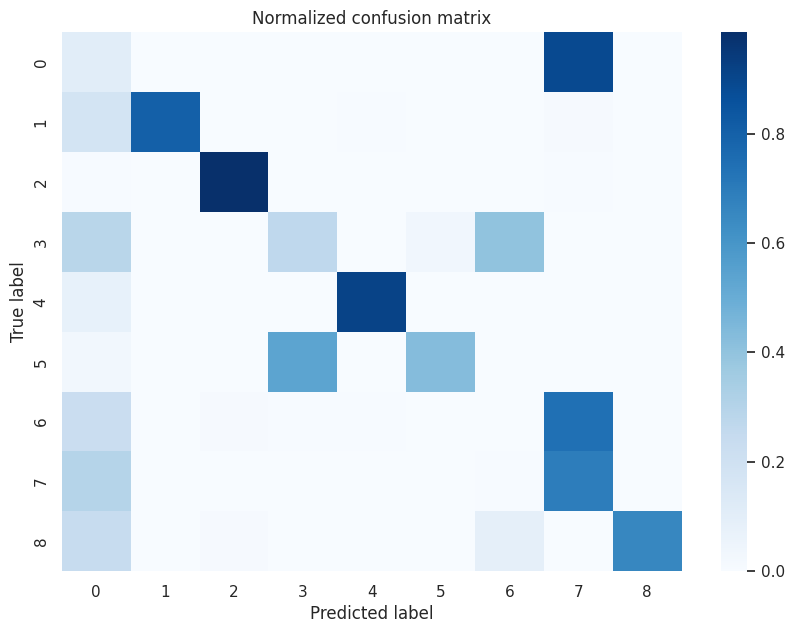

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import torch

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=False, cmap=cmap)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Load the saved results
results = torch.load('/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/your_data/results_prostate.pt')
labels = results['labels']
preds = results['preds']
labels_cpu = labels.cpu().numpy() if hasattr(labels, 'cpu') else np.array(labels)
preds_cpu = preds.cpu().numpy() if hasattr(preds, 'cpu') else np.array(preds)

# Ensure types matches the number of classes in the confusion matrix
num_classes = max(labels_cpu.max(), preds_cpu.max()) + 1
types = [str(i) for i in range(num_classes)]

plot_confusion_matrix(labels_cpu, preds_cpu, types, normalize=True)

In [16]:
import anndata as ad, scanpy as sc
cell_embs = results['cell_embs']
cell_embs_ad = ad.AnnData(cell_embs.numpy())
cell_embs_ad.obs['celltype'] = dataset_sub['celltype']
if 'batch' in dataset_sub.features.keys():
    cell_embs_ad.obs['batch'] = dataset_sub['batch']
    cell_embs_ad.obs['batch'] = cell_embs_ad.obs['batch'].astype(str)
cell_embs_ad.obs['predictions'] = [types[i] for i in preds]
sc.pp.neighbors(cell_embs_ad, use_rep='X', n_neighbors=80)


In [17]:
sc.tl.umap(cell_embs_ad)

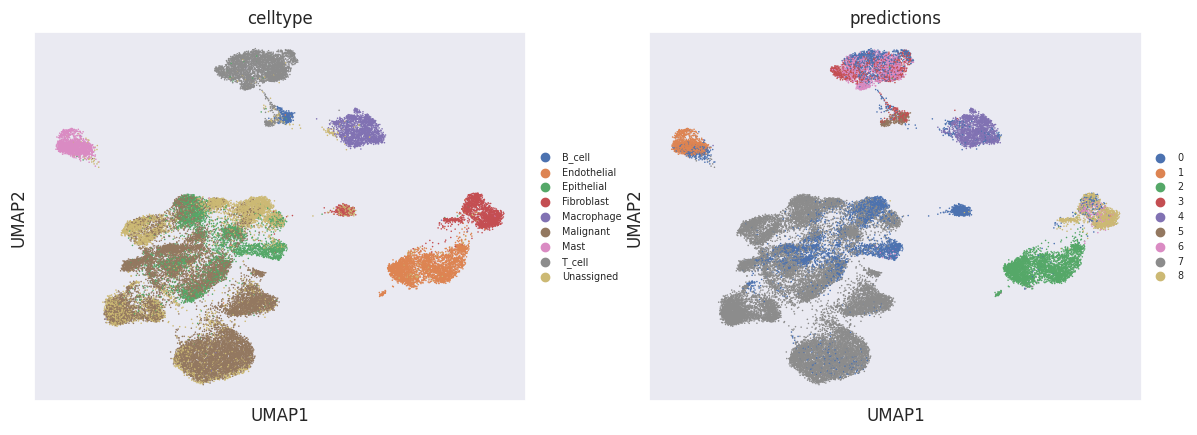

In [18]:
# List of columns you want to color by
color_keys = ['celltype', 'predictions', 'batch']

# Only keep those that exist in .obs
existing_keys = [k for k in color_keys if k in cell_embs_ad.obs.columns]

sc.pl.umap(cell_embs_ad, color=existing_keys, legend_fontsize='xx-small', size=5, legend_fontweight='light')

Loading results...
Dataset: 36424 samples, 9 classes
Classes: ['Malignant', 'Unassigned', 'Epithelial', 'T_cell', 'Endothelial', 'Fibroblast', 'Macrophage', 'Mast', 'B_cell']

Generating ROC curves...


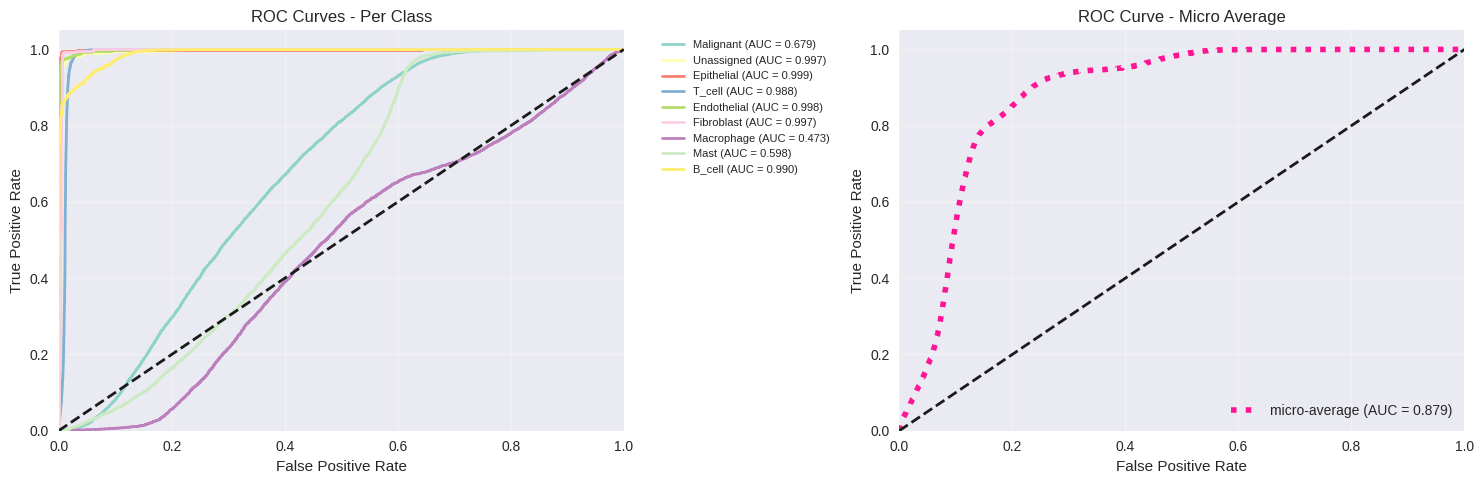

Generating Precision-Recall curves...


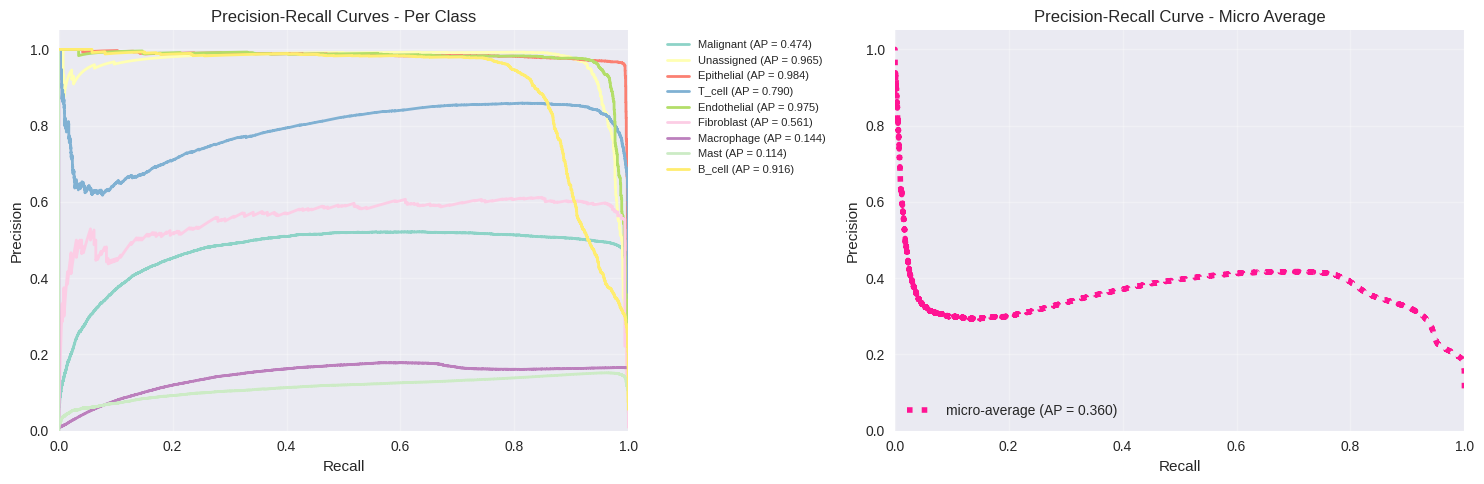

Generating performance summary...


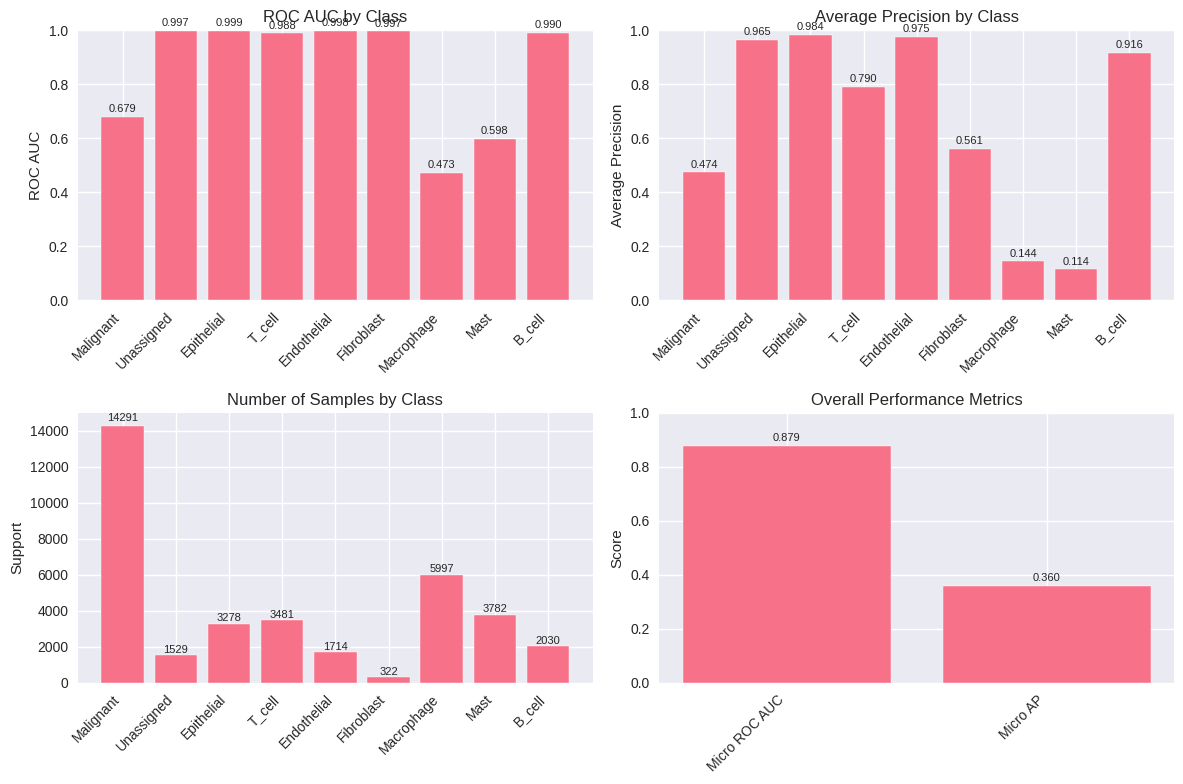


PERFORMANCE SUMMARY
Micro ROC AUC: 0.8786
Micro Average Precision: 0.3597

Per-class metrics:
  Malignant: ROC AUC = 0.6786, AP = 0.4738
  Unassigned: ROC AUC = 0.9974, AP = 0.9646
  Epithelial: ROC AUC = 0.9985, AP = 0.9840
  T_cell: ROC AUC = 0.9883, AP = 0.7900
  Endothelial: ROC AUC = 0.9984, AP = 0.9753
  Fibroblast: ROC AUC = 0.9966, AP = 0.5610
  Macrophage: ROC AUC = 0.4728, AP = 0.1443
  Mast: ROC AUC = 0.5984, AP = 0.1142
  B_cell: ROC AUC = 0.9902, AP = 0.9160


In [19]:
# Roc and PR curves
# =============================================================================
# ROC AND PRECISION-RECALL CURVES FOR LANGCELL RESULTS
# =============================================================================
# Copy and paste this cell into your Jupyter notebook after your results are ready

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, precision_recall_curve, auc,
    roc_auc_score, average_precision_score
)
from sklearn.preprocessing import label_binarize
import json

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def load_results(results_path, type2text_path=None):
    """Load results and cell type information."""
    # Load results
    results = torch.load(results_path, map_location='cpu')
    labels = results['labels'].numpy()
    preds = results['preds'].numpy()
    
    # Load cell type information if available
    cell_types = None
    if type2text_path:
        try:
            with open(type2text_path, 'r') as f:
                type2text = json.load(f)
            cell_types = list(type2text.keys())
        except:
            print("Warning: Could not load type2text file")
    
    # If no cell types provided, use numeric labels
    if cell_types is None:
        n_classes = max(labels.max(), preds.max()) + 1
        cell_types = [f"Class_{i}" for i in range(n_classes)]
    
    # Get prediction scores
    if 'logits' in results:
        scores = results['logits'].numpy()
    elif 'sim_logits' in results and 'ctm_logits' in results:
        # Combine similarity and CTM logits
        alpha = 0.1
        sim_logits = results['sim_logits'].numpy()
        ctm_logits = results['ctm_logits'].numpy()
        scores = alpha * sim_logits + (1 - alpha) * ctm_logits
    else:
        raise ValueError("No prediction scores found in results")
    
    return labels, preds, scores, cell_types

def plot_roc_curves(labels, scores, cell_types, figsize=(15, 5)):
    """Plot ROC curves for all classes."""
    n_classes = len(cell_types)
    
    # Binarize labels
    labels_bin = label_binarize(labels, classes=range(n_classes))
    if n_classes == 2:
        labels_bin = np.hstack([1 - labels_bin, labels_bin])
    
    # Compute ROC curves
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_bin.ravel(), scores.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Individual classes
    colors = plt.cm.Set3(np.linspace(0, 1, n_classes))
    for i, color in zip(range(n_classes), colors):
        ax1.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'{cell_types[i]} (AUC = {roc_auc[i]:.3f})')
    
    ax1.plot([0, 1], [0, 1], 'k--', lw=2)
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curves - Per Class')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # Micro average
    ax2.plot(fpr["micro"], tpr["micro"],
            label=f'micro-average (AUC = {roc_auc["micro"]:.3f})',
            color='deeppink', linestyle=':', linewidth=4)
    ax2.plot([0, 1], [0, 1], 'k--', lw=2)
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve - Micro Average')
    ax2.legend(loc="lower right")
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return roc_auc

def plot_pr_curves(labels, scores, cell_types, figsize=(15, 5)):
    """Plot Precision-Recall curves for all classes."""
    n_classes = len(cell_types)
    
    # Binarize labels
    labels_bin = label_binarize(labels, classes=range(n_classes))
    if n_classes == 2:
        labels_bin = np.hstack([1 - labels_bin, labels_bin])
    
    # Compute PR curves
    precision = dict()
    recall = dict()
    average_precision = dict()
    
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(labels_bin[:, i], scores[:, i])
        average_precision[i] = average_precision_score(labels_bin[:, i], scores[:, i])
    
    # Compute micro-average PR
    precision["micro"], recall["micro"], _ = precision_recall_curve(
        labels_bin.ravel(), scores.ravel()
    )
    average_precision["micro"] = average_precision_score(labels_bin.ravel(), scores.ravel())
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Individual classes
    colors = plt.cm.Set3(np.linspace(0, 1, n_classes))
    for i, color in zip(range(n_classes), colors):
        ax1.plot(recall[i], precision[i], color=color, lw=2,
                label=f'{cell_types[i]} (AP = {average_precision[i]:.3f})')
    
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.set_title('Precision-Recall Curves - Per Class')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # Micro average
    ax2.plot(recall["micro"], precision["micro"],
            label=f'micro-average (AP = {average_precision["micro"]:.3f})',
            color='deeppink', linestyle=':', linewidth=4)
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curve - Micro Average')
    ax2.legend(loc="lower left")
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return average_precision

def plot_performance_summary(labels, scores, cell_types, figsize=(12, 8)):
    """Plot a summary of performance metrics."""
    n_classes = len(cell_types)
    
    # Binarize labels
    labels_bin = label_binarize(labels, classes=range(n_classes))
    if n_classes == 2:
        labels_bin = np.hstack([1 - labels_bin, labels_bin])
    
    # Calculate metrics
    roc_auc_scores = []
    ap_scores = []
    support = []
    
    for i in range(n_classes):
        roc_auc_scores.append(roc_auc_score(labels_bin[:, i], scores[:, i]))
        ap_scores.append(average_precision_score(labels_bin[:, i], scores[:, i]))
        support.append(np.sum(labels_bin[:, i]))
    
    # Overall metrics
    micro_roc_auc = roc_auc_score(labels_bin.ravel(), scores.ravel())
    micro_ap = average_precision_score(labels_bin.ravel(), scores.ravel())
    
    # Plot
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=figsize)
    
    # ROC AUC by class
    bars1 = ax1.bar(range(n_classes), roc_auc_scores)
    ax1.set_title('ROC AUC by Class')
    ax1.set_ylabel('ROC AUC')
    ax1.set_xticks(range(n_classes))
    ax1.set_xticklabels(cell_types, rotation=45, ha='right')
    ax1.set_ylim(0, 1)
    for bar, value in zip(bars1, roc_auc_scores):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontsize=8)
    
    # AP by class
    bars2 = ax2.bar(range(n_classes), ap_scores)
    ax2.set_title('Average Precision by Class')
    ax2.set_ylabel('Average Precision')
    ax2.set_xticks(range(n_classes))
    ax2.set_xticklabels(cell_types, rotation=45, ha='right')
    ax2.set_ylim(0, 1)
    for bar, value in zip(bars2, ap_scores):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontsize=8)
    
    # Support by class
    bars3 = ax3.bar(range(n_classes), support)
    ax3.set_title('Number of Samples by Class')
    ax3.set_ylabel('Support')
    ax3.set_xticks(range(n_classes))
    ax3.set_xticklabels(cell_types, rotation=45, ha='right')
    for bar, value in zip(bars3, support):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + value*0.01,
                f'{value}', ha='center', va='bottom', fontsize=8)
    
    # Overall metrics
    overall_metrics = {
        'Micro ROC AUC': micro_roc_auc,
        'Micro AP': micro_ap
    }
    
    ax4.bar(range(len(overall_metrics)), list(overall_metrics.values()))
    ax4.set_title('Overall Performance Metrics')
    ax4.set_ylabel('Score')
    ax4.set_xticks(range(len(overall_metrics)))
    ax4.set_xticklabels(overall_metrics.keys(), rotation=45, ha='right')
    ax4.set_ylim(0, 1)
    for i, (key, value) in enumerate(overall_metrics.items()):
        ax4.text(i, value + 0.01, f'{value:.3f}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'roc_auc': roc_auc_scores,
        'ap': ap_scores,
        'support': support,
        'micro_roc_auc': micro_roc_auc,
        'micro_ap': micro_ap
    }

# =============================================================================
# RUN THE ANALYSIS (AFTER YOUR RESULTS ARE READY)
# =============================================================================

# Configuration - Update these paths after your results are ready
results_path = "/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/your_data/results_prostate.pt"
type2text_path = "/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/LangCell/your_data/type2text_prostate.json"

print("Loading results...")
labels, preds, scores, cell_types = load_results(results_path, type2text_path)

print(f"Dataset: {len(labels)} samples, {len(cell_types)} classes")
print(f"Classes: {cell_types}")
print()

print("Generating ROC curves...")
roc_auc = plot_roc_curves(labels, scores, cell_types)

print("Generating Precision-Recall curves...")
ap_scores = plot_pr_curves(labels, scores, cell_types)

print("Generating performance summary...")
metrics = plot_performance_summary(labels, scores, cell_types)

print("\n" + "="*50)
print("PERFORMANCE SUMMARY")
print("="*50)
print(f"Micro ROC AUC: {metrics['micro_roc_auc']:.4f}")
print(f"Micro Average Precision: {metrics['micro_ap']:.4f}")
print()
print("Per-class metrics:")
for i, cell_type in enumerate(cell_types):
    print(f"  {cell_type}: ROC AUC = {roc_auc[i]:.4f}, AP = {ap_scores[i]:.4f}")
print("="*50)

It is evident that the cell embeddings generated directly by LangCell, without any fine-tuning, possess desirable properties: they cluster by cell type and eliminate batch effects. By comparing the left and middle plots, one can intuitively observe that LangCell is capable of reliably annotating cell types in a zero-shot scenario.
